<a href="https://colab.research.google.com/github/sjtae/data_science_project/blob/main/project01/Python_Project/Employee_Payroll_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Payroll Analysis

In [110]:
# Libraries
from pathlib import Path
import sqlite3
import pandas as pd
from tabulate import tabulate
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Create a relational database

In [111]:
Path('payroll_database.db').touch()

In [112]:
# connect with sqlite database
conn = sqlite3.connect('payroll_database.db')
c = conn.cursor()

In [113]:
dtype_mapping = {
    'RECORD_NBR': str,
    'PAY_YEAR': str,
    'DEPARTMENT_NO': str,
    'JOB_CLASS_PGRADE': str,
    'JOB_TITLE': str,
    'EMPLOYMENT_TYPE': str,
    'JOB_STATUS': str,
    'MOU': str,
    'MOU_TITLE': str,
    'REGULAR_PAY': float,
    'OVERTIME_PAY': float,
    'ALL_OTHER_PAY': float,
    'TOTAL_PAY': float,
    'CITY_RETIREMENT_CONTRIBUTIONS': float,
    'BENEFIT_PAY': float,
    'GENDER': str,
    'ETHNICITY': str
}

# read our dataset and mapping the column type
df = pd.read_csv('payroll.csv', dtype = dtype_mapping)

# clean the MOU and MOU_TITLE
df['MOU'] = df['MOU'].replace([None, 0.0], '00')
df['MOU_TITLE'].fillna('NON-REPRESENTED', inplace=True)


In [114]:
# create payroll table in database
payroll_table = df.to_sql('payroll', conn, if_exists='replace', index=False)

In [115]:
# create a employee payroll table as a fact table
employee_payroll = '''CREATE TABLE employee_payroll AS
                                    SELECT
                                        RECORD_NBR,
                                        PAY_YEAR,
                                        DEPARTMENT_NO,
                                        JOB_CLASS_PGRADE,
                                        JOB_TITLE,
                                        EMPLOYMENT_TYPE,
                                        JOB_STATUS,
                                        MOU,
                                        REGULAR_PAY,
                                        OVERTIME_PAY,
                                        ALL_OTHER_PAY,
                                        TOTAL_PAY,
                                        CITY_RETIREMENT_CONTRIBUTIONS,
                                        BENEFIT_PAY,
                                        GENDER,
                                        ETHNICITY
                                    FROM payroll'''
conn.execute(employee_payroll)

# commit changes
conn.commit()

In [116]:
# create a department table as a dimensional table
department = '''CREATE TABLE department AS
                        SELECT DISTINCT
                            DEPARTMENT_NO,
                            DEPARTMENT_TITLE
                        FROM payroll
                        ORDER BY 1'''
conn.execute(department)

# commit changes
conn.commit()

In [117]:
# create a MOU table as a dimensional table
mou = '''CREATE TABLE mou AS
                SELECT DISTINCT
                    MOU,
                    MOU_TITLE
                FROM payroll
                ORDER BY 1'''
conn.execute(mou)

# commit changes
conn.commit()

### Data model

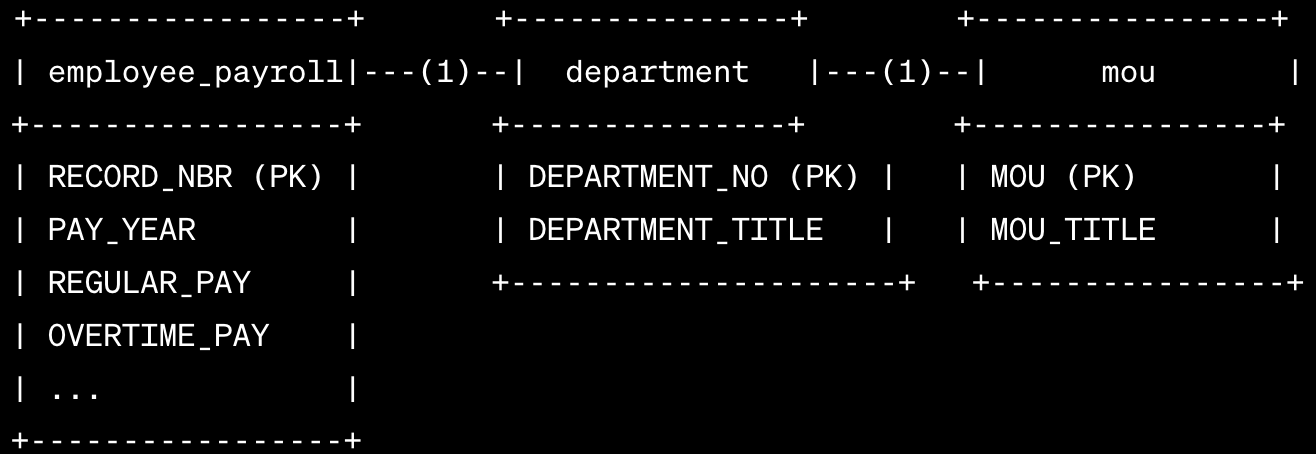

### Create partitioning table by year

In [118]:
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Iterate over the years and create separate tables for each partition
for year in years:
    create_partition_sql = f'''
    CREATE TABLE partition_payroll_{year} AS
    SELECT
        RECORD_NBR,
        PAY_YEAR,
        DEPARTMENT_NO,
        JOB_CLASS_PGRADE,
        JOB_TITLE,
        EMPLOYMENT_TYPE,
        JOB_STATUS,
        MOU,
        REGULAR_PAY,
        OVERTIME_PAY,
        ALL_OTHER_PAY,
        TOTAL_PAY,
        CITY_RETIREMENT_CONTRIBUTIONS,
        BENEFIT_PAY,
        GENDER,
        ETHNICITY
    FROM employee_payroll
    WHERE PAY_YEAR = '{year}'
    '''
    conn.execute(create_partition_sql)

# Commit the changes
conn.commit()

print("Tables for partition_payroll have been created.")

Tables for partition_payroll have been created.


In [119]:
# try to query from partitioning table
pd.read_sql('select * from partition_payroll_2014 limit 3', conn)

,RECORD_NBR,PAY_YEAR,DEPARTMENT_NO,JOB_CLASS_PGRADE,JOB_TITLE,EMPLOYMENT_TYPE,JOB_STATUS,MOU,REGULAR_PAY,OVERTIME_PAY,ALL_OTHER_PAY,TOTAL_PAY,CITY_RETIREMENT_CONTRIBUTIONS,BENEFIT_PAY,GENDER,ETHNICITY
0,3131323037,2014,76,7291-0,CONSTRUCTION INSPECTOR,FULL_TIME,NOT_ACTIVE,05,91713.86,0.00,11103.61,102817.47,27202.33,17423.04,MALE,CAUCASIAN
1,3131323038,2014,4,3156-A,CUSTODIAN - AIRPORTS,FULL_TIME,ACTIVE,15,48880.83,3378.29,6383.58,58642.70,14498.05,12074.40,FEMALE,HISPANIC
2,313132313031,2014,4,3156-A,CUSTODIAN - AIRPORTS,FULL_TIME,NOT_ACTIVE,15,48880.83,8198.97,6383.58,63463.38,14498.05,6703.20,MALE,BLACK


In [120]:
# Get a list of all tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()
print(table_names)

[('payroll',), ('employee_payroll',), ('department',), ('mou',), ('partition_payroll_2013',), ('partition_payroll_2014',), ('partition_payroll_2015',), ('partition_payroll_2016',), ('partition_payroll_2017',), ('partition_payroll_2018',), ('partition_payroll_2019',), ('partition_payroll_2020',), ('partition_payroll_2021',), ('partition_payroll_2022',)]


## Trend Analysis

### Descriptive statistics for total pay for each department


In [121]:
total_pay_each_dept = pd.read_sql('''
            SELECT
                dp.DEPARTMENT_TITLE,
                COUNT(*) AS record_count,
                SUM(TOTAL_PAY) AS total_pay,
                AVG(TOTAL_PAY) AS average_pay,
                MIN(TOTAL_PAY) AS min_pay,
                MAX(TOTAL_PAY) as max_pay
            FROM employee_payroll em
            JOIN department dp
            ON em.DEPARTMENT_NO = dp.DEPARTMENT_NO
            GROUP BY 1
            ORDER BY 3 DESC''', conn)

# Convert the DataFrame to a table and print it
total_pay = tabulate(total_pay_each_dept, headers='keys', tablefmt='pretty', showindex=False)
print(total_pay)

+--------------------------------------------------------------+--------------+--------------------+--------------------+-----------+-----------+
|                       DEPARTMENT_TITLE                       | record_count |     total_pay      |    average_pay     |  min_pay  |  max_pay  |
+--------------------------------------------------------------+--------------+--------------------+--------------------+-----------+-----------+
|                            POLICE                            |    150016    | 14149243456.679764 | 94318.22910009441  | -5658.06  | 592439.02 |
|                       WATER AND POWER                        |    109906    | 11632546209.020002 | 105840.86591287101 |   3.32    | 470836.62 |
|                             FIRE                             |    42294     | 6022966903.970026  | 142407.12403579766 |  -775.92  | 582192.06 |
|                           AIRPORTS                           |    42762     |  3049320907.66001  | 71309.12744165404  |  -

### Compare the years of total pay

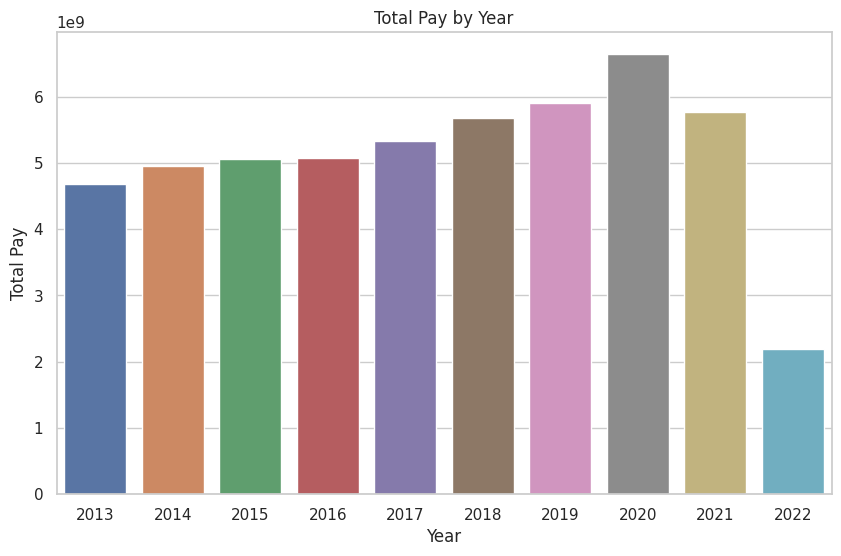

In [122]:
years = pd.read_sql('''
            SELECT
                PAY_YEAR,
                ROUND(SUM(TOTAL_PAY),2) AS total_pay,
                ROUND(SUM(OVERTIME_PAY),2) AS ot_pay
            FROM employee_payroll
            GROUP BY 1
            ORDER BY 1''', conn)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='PAY_YEAR', y='total_pay', data=years)

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Total Pay')
plt.title('Total Pay by Year')

# Show the plot
plt.show()

#### Total pay showed a consistent upward trend in the years leading up to 2020, indicating a gradual increase in earnings. However, the years 2021-2022 saw a significant drop in total pay, which can be attributed to the impact of the COVID-19 pandemic.

### Descriptive statistics for overtime pay for each department


In [123]:
ot_each_department = pd.read_sql('''
    SELECT
        dp.DEPARTMENT_TITLE,
        COUNT(*) AS record_count,
        SUM(OVERTIME_PAY) AS total_ot_pay,
        AVG(OVERTIME_PAY) AS average_ot_pay,
        MIN(OVERTIME_PAY) AS min_ot_pay,
        MAX(OVERTIME_PAY) as max_ot_pay
    FROM employee_payroll em
    JOIN department dp
    ON em.DEPARTMENT_NO = dp.DEPARTMENT_NO
    GROUP BY 1
    ORDER BY 3 DESC''', conn)

# Convert the DataFrame to a table and print it
ot = tabulate(ot_each_department, headers='keys', tablefmt='pretty', showindex=False)
print(ot)


+--------------------------------------------------------------+--------------+--------------------+-----------------------+------------+------------+
|                       DEPARTMENT_TITLE                       | record_count |    total_ot_pay    |    average_ot_pay     | min_ot_pay | max_ot_pay |
+--------------------------------------------------------------+--------------+--------------------+-----------------------+------------+------------+
|                             FIRE                             |    42294     | 1874280934.8900113 |   44315.52785004992   | -24903.62  | 434393.94  |
|                       WATER AND POWER                        |    109906    | 1795904528.0200152 |   16405.14951786772   |  -3527.16  |  319724.1  |
|                            POLICE                            |    150016    | 1191431963.0499709 |   7942.032603522097   |  -2100.86  | 152044.45  |
|                           AIRPORTS                           |    42762     | 303850299.4499

### Compare the years of overtime pay

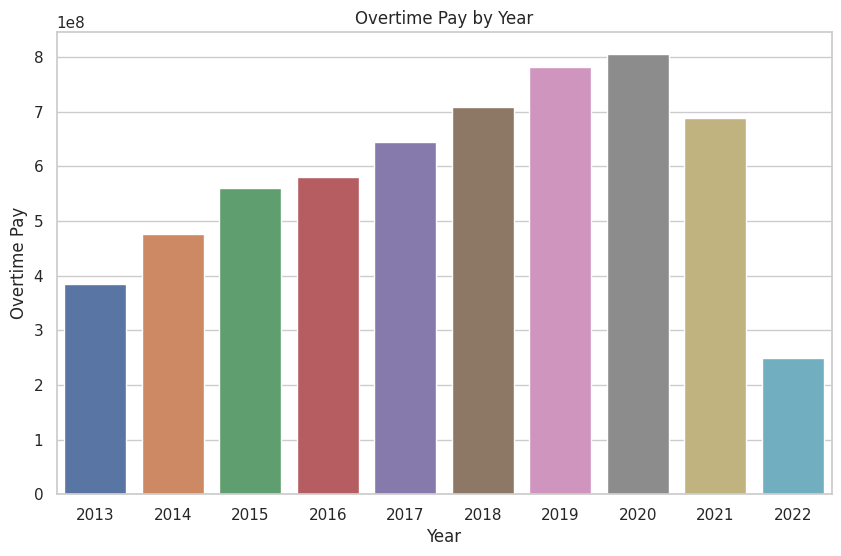

In [124]:
years = pd.read_sql('''
            SELECT
                PAY_YEAR,
                ROUND(SUM(TOTAL_PAY),2) AS total_pay,
                ROUND(SUM(OVERTIME_PAY),2) AS ot_pay
            FROM employee_payroll
            GROUP BY 1
            ORDER BY 1''', conn)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='PAY_YEAR', y='ot_pay', data=years)

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Overtime Pay')
plt.title('Overtime Pay by Year')

# Show the plot
plt.show()

#### Overtime pay had been steadily increasing over the years, reflecting a moderate rise in extra work. However, a significant drop occurred in 2021-2022, possibly due to the impact of COVID-19, disrupting work patterns and leading to reduced overtime opportunities.

### Hypothesis testing for differences in overtime pay between genders

In [125]:
# Filter data for male and female employees
male_overtime = df[df['GENDER'] == 'MALE']['OVERTIME_PAY']
female_overtime = df[df['GENDER'] == 'FEMALE']['OVERTIME_PAY']

# drop na value
male_overtime = male_overtime.dropna()
female_overtime = female_overtime.dropna()

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(male_overtime, female_overtime, equal_var=False)

# Define the significance level (alpha), 5% in this case
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in average overtime pay.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in average overtime pay.")


Reject the null hypothesis: There is a significant difference in average overtime pay.


#### The result of the hypothesis test indicates that we can reject the null hypothesis. In other words, there is a statistically significant difference in the average overtime pay between male and female employees. This suggests that, on average, one gender tends to receive a different amount of overtime pay compared to the other.